In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import warnings
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import skew
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats
import statsmodels.stats.multitest as multi

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")

In [2]:
df_listings = pd.read_csv("detailed_listings_formatted.csv")

for data in [df_listings]:
    display(data.head())
    print(data.shape)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,...,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3123306,https://www.airbnb.com/rooms/3123306,20230626155752,2023-06-26,previous scrape,Home in Rio · 2 bedrooms · 2 beds · 1 bath,apartamento espaçoso com varanda e vista panor...,vizinhança muito hospitaleira e festiva,https://a0.muscache.com/pictures/39851024/a51c...,15864313,https://www.airbnb.com/users/show/15864313,José Mario,2014-05-22,"Rio, Brazil",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/15864313/prof...,https://a0.muscache.com/im/users/15864313/prof...,Vidigal,1.0,1.0,"['email', 'phone']",...,f,0,0,0,0,2023-06-26,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
1,912633,https://www.airbnb.com/rooms/912633,20230626155752,2023-06-26,previous scrape,Home in Rio de Janeiro · 1 bedroom · 2 beds · ...,<b>The space</b><br />Come have fun with Carni...,NaN,https://a0.muscache.com/pictures/13482859/f724...,4897168,https://www.airbnb.com/users/show/4897168,Taryhk,2013-01-29,"Rio de Janeiro, Brazil",Meu nome é Taryhk.\nSou bailarino e músico. T...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/4897168/profi...,https://a0.muscache.com/im/users/4897168/profi...,NaN,1.0,2.0,"['email', 'phone']",...,f,0,0,0,0,2023-06-26,1,0,0,2013-02-15,2013-02-15,5.00,5.0,4.00,5.00,5.00,4.00,5.00,NaN,f,1,0,0,1,0.01
2,29051942,https://www.airbnb.com/rooms/29051942,20230626155752,2023-06-27,city scrape,Rental unit in Ipanema · Studio · 1 bed · 1 bath,Central location ipanema <br />Walking distanc...,NaN,https://a0.muscache.com/pictures/ce7ceee5-25a5...,4307081,https://www.airbnb.com/users/show/4307081,Nereu A,2012-12-02,"Rio de Janeiro, Brazil","30 anos de experiencia na area de turismo, idi...",within an hour,98%,28%,t,https://a0.muscache.com/im/pictures/user/6c5b1...,https://a0.muscache.com/im/pictures/user/6c5b1...,Ipanema,56.0,85.0,['phone'],...,t,30,60,90,362,2023-06-27,1,0,0,2018-10-07,2018-10-07,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,52,43,9,0,0.02
3,52279209,https://www.airbnb.com/rooms/52279209,20230626155752,2023-06-26,previous scrape,Rental unit in Botafogo · ★3.33 · 1 bedroom · ...,NaN,NaN,https://a0.muscache.com/pictures/f50a0338-be21...,172482654,https://www.airbnb.com/users/show/172482654,Evilene,2018-02-09,"Rio de Janeiro, Brazil",NaN,within an hour,100%,92%,f,https://a0.muscache.com/im/pictures/user/b6bd3...,https://a0.muscache.com/im/pictures/user/b6bd3...,Botafogo,17.0,33.0,"['email', 'phone']",...,t,0,0,0,0,2023-06-26,3,2,0,2021-11-03,2023-02-26,3.33,4.0,3.67,4.67,3.67,4.33,3.67,NaN,f,14,14,0,0,0.15
4,13561531,https://www.airbnb.com/rooms/13561531,20230626155752,2023-06-26,previous scrape,Rental unit in Rio de Janeiro · 3 bedrooms · 3...,Meu espaço é perto de shopping downtown. Você ...,NaN,https://a0.muscache.com/pictures/bf0f69b3-c315...,69583438,https://www.airbnb.com/users/show/69583438,Eli,2016-04-29,NaN,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/3fb86...,https://a0.muscache.com/im/pictures/user/3fb86...,NaN,1.0,2.0,['email'],...,f,0,0,0,0,2023-06-26,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


(31401, 75)


In [3]:
# Retrieve the creation date of the dataframe for feature engineering
df_listing_last_scraped = pd.Timestamp(df_listings.last_scraped[0])

# Drop duplicate columns
df_listings = df_listings.T.drop_duplicates().T

# Drop columns with full NA
df_listings.dropna(axis=1,how="all",inplace=True)

# Drop columns with only one unique value
df_listings.drop([c for c in df_listings.columns if df_listings[c].nunique()==1],axis=1,inplace=True)

# Drop columns representing url
df_listings.drop(df_listings.columns[df_listings.columns.str.contains("url")],axis=1,inplace=True)

# Reformat the money related columns
df_listings.price = df_listings.price.str.replace(r"$","").str.replace(",","").astype("float32")

#Reformat latitude and longitude
df_listings.latitude = df_listings.latitude.str.replace(".","")
df_listings.longitude = df_listings.longitude.str.replace(".","")

#Reformat the bathrooms_text
def transform_bathrooms_text(df, column_name):
    # Use regular expressions to keep only the numbers in the column
    df[column_name] = df[column_name].str.replace(r'[^0-9.]', '', regex=True)

    df[column_name].replace('', np.nan, inplace=True)
    
    # Convert the values to float to handle decimal numbers
    df[column_name] = df[column_name].astype(float)
    
    # Return just the modified column as a Series
    return df[column_name]
    
df_listings['bathrooms_text'] = transform_bathrooms_text(df_listings, 'bathrooms_text')

# Transform the date related columns
df_listings['host_since_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.host_since)).dt.days
df_listings['last_review_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.last_review)).dt.days
df_listings['first_review_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.first_review)).dt.days

# Reformat other features
df_listings['host_response_time'] = df_listings.host_response_time.map({"within an hour":1,"within a few hours":12,\
                                                                        "within a day":24,"a few days or more":48})
df_listings.host_response_rate = df_listings.host_response_rate.str.replace("%","").astype("float32")

# Create a feature count the number of host verification methods
host_verifications = np.unique(np.concatenate(df_listings.host_verifications.map(lambda x:x[1:-1].replace("'","").split(", "))))[1:]
matrix_verifications=[[veri in row for row in df_listings.host_verifications.map(lambda x:x[1:-1].replace("'","").split(", ")) ] for veri in host_verifications]
df_listings['host_verificationCount'] = pd.DataFrame(matrix_verifications,index=host_verifications).T.sum(1)
print('Done')

Done


## Feature selection

In [4]:
features_host = ['host_is_superhost','host_about','host_response_time','host_response_rate', 'host_listings_count',
                 'host_verificationCount','host_has_profile_pic','host_identity_verified','host_since_deltaDays',
                 'calculated_host_listings_count']

features_property = ['description','neighborhood_overview','neighbourhood','latitude','longitude',
                     'property_type','room_type','accommodates','bathrooms_text','bedrooms','beds',
                     'amenities','price','minimum_nights','maximum_nights']

features_traveler = ['number_of_reviews','last_review_deltaDays','first_review_deltaDays','review_scores_rating',
                     'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                     'review_scores_location','review_scores_value','instant_bookable','reviews_per_month']

features = features_host + features_property + features_traveler
df_listings_filtered = df_listings[features]

## Numeric and bool features

In [5]:
numeric_feature = ['host_listings_count','calculated_host_listings_count','latitude','longitude','accommodates','bathrooms_text',
                   'bedrooms','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating',
                   'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                   'review_scores_location','review_scores_value', 'review_scores_rating' ,'review_scores_accuracy',
                   'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
                   'review_scores_value' ,'reviews_per_month'] 

bool_feature = ['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable']

# Transform the bool features
for bool_f in bool_feature:
  df_listings_filtered[bool_f] = df_listings_filtered[bool_f].map({'t':1,'f':0}).astype('bool')

# Transform the numerical features
for num_f in numeric_feature:
    df_listings_filtered[num_f] = df_listings_filtered[num_f].astype("float32")

## Dealing with unique amenities 

In [25]:
# Transform the amenities feature into a one-hot encoding matrix
unique_amenities = np.unique(np.concatenate(df_listings_filtered.amenities.str[1:-1].str.replace('"','')\
                                            .str.split(",")))[1:]
matrix_amenities=[[amen in row for row in df_listings_filtered.amenities.str[1:-1].str.replace('"','').\
                   str.split(",") ] for amen in unique_amenities]
df_amenities = pd.DataFrame(matrix_amenities,index=unique_amenities).T

# Drop amenities features that appear in less than 5% of samples to avoid overfitting
df_amenities.drop(df_amenities.columns.values[np.where(df_amenities.mean()<0.05)],axis=1,inplace=True)
df_listings_filtered_amenities = pd.concat([df_listings_filtered,df_amenities],axis=1)

## Looking for missing values imputation

In [26]:
print(df_listings_filtered_amenities.isna().mean().sort_values(ascending=False).head(35))

host_about                        0.500430
neighbourhood                     0.479666
neighborhood_overview             0.479666
host_response_rate                0.265119
host_response_time                0.265119
review_scores_location            0.255884
review_scores_communication       0.255852
review_scores_accuracy            0.255852
review_scores_value               0.255852
review_scores_cleanliness         0.255820
review_scores_checkin             0.255820
reviews_per_month                 0.250756
last_review_deltaDays             0.250756
review_scores_rating              0.250756
first_review_deltaDays            0.250756
bedrooms                          0.234865
description                       0.022515
beds                              0.006210
bathrooms_text                    0.002420
host_listings_count               0.000096
host_since_deltaDays              0.000096
 Long term stays allowed          0.000000
host_is_superhost                 0.000000
 Microwave 

# Checking how these numbers are affected if only the listings with reviews are taken into account.

In [27]:
df_listings_filtered_amenities = df_listings_filtered_amenities.query('number_of_reviews>0')
print(df_listings_filtered_amenities.isna().mean().sort_values(ascending=False).head(35))

host_about                     0.471288
neighborhood_overview          0.415565
neighbourhood                  0.415565
bedrooms                       0.230544
host_response_time             0.189994
host_response_rate             0.189994
description                    0.019807
review_scores_location         0.006843
review_scores_value            0.006801
review_scores_accuracy         0.006801
review_scores_communication    0.006801
review_scores_cleanliness      0.006758
review_scores_checkin          0.006758
beds                           0.005186
bathrooms_text                 0.001615
host_is_superhost              0.000000
 Mini fridge                   0.000000
 Mountain view                 0.000000
 Long term stays allowed       0.000000
 Netflix                       0.000000
 Ocean view                    0.000000
 Outdoor dining area           0.000000
 Outdoor furniture             0.000000
 Outdoor shower                0.000000
 Oven                          0.000000


# Since there's a huge difference, those listings won't be taken into account. The next step is to treat NA for numeric and object features.

In [29]:
df_listings_filtered_amenities_cleaned = df_listings_filtered_amenities.copy()

# Numeric features will be treated with the median value of the availbale data. This is done to avoid distorting the distributuion
# of the variable
feature_fillna_median = ['host_response_time','host_response_rate','bedrooms',
                         'bathrooms_text','review_scores_rating','review_scores_communication','review_scores_cleanliness',
                         'review_scores_location','review_scores_value','review_scores_accuracy','review_scores_checkin']
df_listings_filtered_amenities_cleaned[feature_fillna_median] = df_listings_filtered_amenities_cleaned[feature_fillna_median].fillna(
                                                                df_listings_filtered_amenities_cleaned[feature_fillna_median].median())

# Categorical features will be treated with the mode, to preserve the distribution of the variable and make it suitable
# for nominal or ordinal data
feature_fillna_empty =  ['neighbourhood','host_about','neighborhood_overview']
df_listings_filtered_amenities_cleaned[feature_fillna_empty] = df_listings_filtered_amenities_cleaned[feature_fillna_empty].fillna('')

# Numerical features
df_num = df_listings_filtered_amenities_cleaned.select_dtypes(exclude='object')
# One hot encoding categorical features
df_cat = pd.get_dummies(df_listings_filtered_amenities_cleaned.select_dtypes(include='object')[['property_type','room_type']])
# Drop one hot categorical feature columns appearing less then 5% of samples
catFeatureToDrop = df_cat.columns.where(df_cat.mean()<0.05).dropna()
df_cat.drop(catFeatureToDrop,axis=1,inplace=True)
df_cat = df_cat.astype("bool")
df_total = pd.concat([df_num,df_cat],axis=1)

## Checking the key factors to maximize performance and profits on airbnb

The evaluation of success may be measured by the "reviews_per_month" metric, along with the "review_scores_rating". A product of both makes a metric that avoids bad reviews and values the frequency of the good ones.

Also, in order to avoid redundancy, all of the metrics realted to rating or the host should be dropped, as the calculation aims for the properties.

In [30]:
# Create the performance metric
df_total['performance'] = df_total.reviews_per_month * df_num.review_scores_rating
# Drawing host and review related features
featureToDrop = [f for f in df_total.columns.values if "review" in f or 'host' in f]
featureToDrop

['host_is_superhost',
 'host_response_time',
 'host_response_rate',
 'host_listings_count',
 'host_verificationCount',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_since_deltaDays',
 'calculated_host_listings_count',
 'number_of_reviews',
 'last_review_deltaDays',
 'first_review_deltaDays',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

Using a Ridge Regression model in order to ensure feature interpretabillity

In [ ]:
X = df_total.drop(featureToDrop+['performance'],axis=1)
y = df_total.performance
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2').fit(X, y)
print("r2 score:{:.3f}".format(clf.score(X,y)))

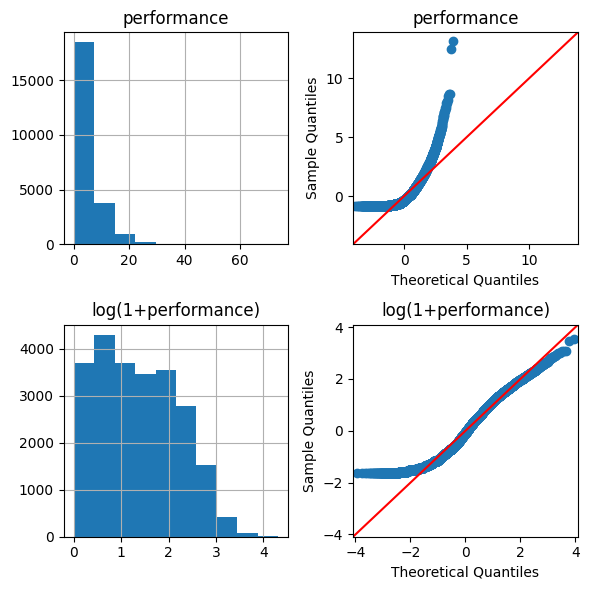

In [32]:
matplotlib.rcParams['figure.figsize'] = (6,6)
fig = plt.figure()

performance = df_total['performance']
log_performance = np.log1p(performance)
# histogram of performance 
ax = fig.add_subplot(2, 2, 1)
performance.hist(ax=ax)
plt.title("performance")

# qq-plot of performance
ax = fig.add_subplot(2, 2, 2)
sm.qqplot((performance-performance.mean())/performance.std(),line='45',ax=ax)
plt.title("performance")

# histogram of log transformed performance
ax = fig.add_subplot(2, 2, 3)
log_performance.hist(ax=ax)
plt.title("log(1+performance)")

# qqplot of log transformed performance
ax = fig.add_subplot(2, 2, 4)
sm.qqplot((log_performance-log_performance.mean())/log_performance.std(),line='45',ax=ax)
plt.title("log(1+performance)")
plt.tight_layout()

In [34]:
num_feature = df_total.select_dtypes(include="number").dtypes.index.values

# Compute the sknewness, log transform features with abs(skewness)>0.75
skewed_feats = df_total[num_feature].apply(lambda x:x.skew())
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
skewed_feats = skewed_feats.index
# Helper function transforming features containing negative values 
# to features only containing nonnegative values
def moveToNonNegative(series):
  if series.min()<0:
    series = series-series.min()
  return series 

df_total[skewed_feats] = df_total[skewed_feats].apply(moveToNonNegative)
df_total[skewed_feats] = np.log1p(df_total[skewed_feats])

In [35]:
X = df_total.drop(featureToDrop+['performance'],axis=1)
y = df_total.performance
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2').fit(X, y)
print("r2 score:{:.3f}".format(clf.score(X,y)))

r2 score:-3753859193952912701503256286724096.000


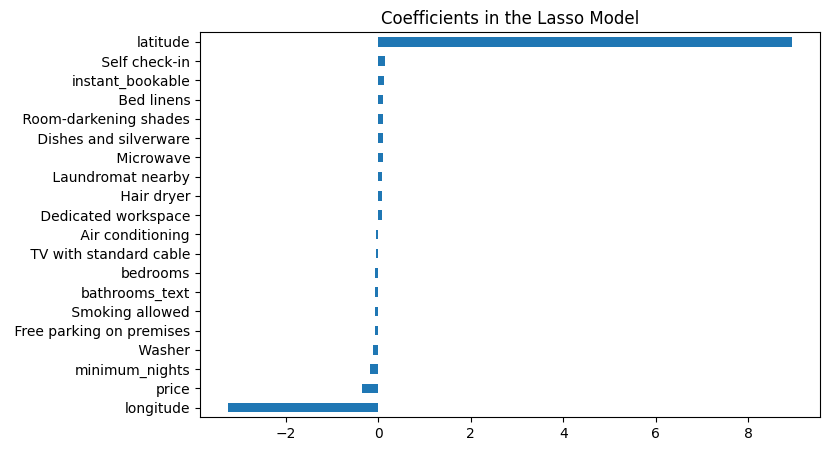

In [36]:
coef = pd.Series(clf.coef_, index = X.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()